# Non-linear regression with Pytorch

Adapted from: https://github.com/mpi-astronomy/data_science_training_materials/blob/main/files/ml-intro/day2-solutions.ipynb

This notebooks implements a multilayer perceptron to perform a non-linear regression.

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Generate mock data

Text(0, 0.5, 'y')

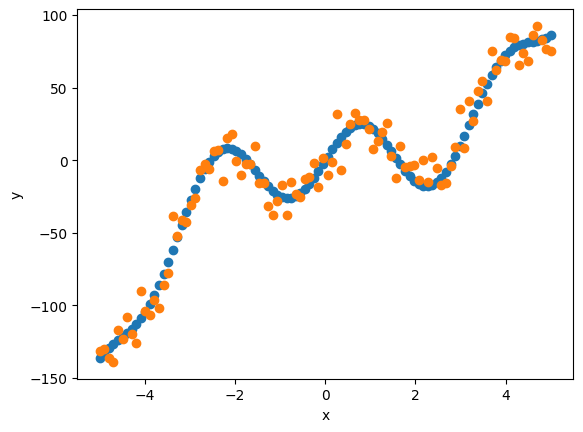

In [3]:
def ftrue(x):
    return x**3 - x**2 + 25*np.sin(2*x)

xxx = np.linspace(-5,5,100)
yyy = ftrue(xxx) + np.random.normal(0,10,len(xxx))

plt.scatter( xxx , ftrue(xxx) )
plt.scatter( xxx , yyy )
plt.xlabel('x')
plt.ylabel('y')

## Build the network

We implement the neural network as a class.

For a fully-connected network, the architecture can be described as a list of numbers given the input dimension, the dimension of each individual hidden layer, and the output. Here the input has dimension 1 (the value of x) and the output has dimension 1 too (the predicted value of y).

In [6]:
from typing import Sequence

# number of nodes per layer (input, ..., output)
layout = [1, 10, 10, 10, 1]

class MLP(nn.Module):
    ''' Multi-layer perceptron for non-linear regression. '''
    def __init__(self, layout: Sequence[int]):
        super().__init__()  # initialize following nn.Module
        n_inputs = layout[0]
        n_outputs = layout[-1]
        n_hidden = layout[1:-1]
        
        self.sequence = nn.Sequential()
        self.sequence.add_module("input", nn.Linear(n_inputs, n_hidden[0]))
        self.sequence.add_module("input_activation", nn.ReLU())
        for e, (n1,n2) in enumerate(zip(n_hidden[:-1],n_hidden[1:])):
            self.sequence.add_module(f"hidden_{e:d}",nn.Linear(n1,n2))
            self.sequence.add_module(f"hidden_activation_{e:d}", nn.ReLU())    
            
        self.sequence.add_module("output", nn.Linear(n_hidden[-1],n_outputs) ) 
        
                                 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequence(x)

    
model = MLP(layout)
model

MLP(
  (sequence): Sequential(
    (input): Linear(in_features=1, out_features=10, bias=True)
    (input_activation): ReLU()
    (hidden_0): Linear(in_features=10, out_features=10, bias=True)
    (hidden_activation_0): ReLU()
    (hidden_1): Linear(in_features=10, out_features=10, bias=True)
    (hidden_activation_1): ReLU()
    (output): Linear(in_features=10, out_features=1, bias=True)
  )
)

Note that we could also implement this as:

In [10]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
)
model

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

Or, to be able to name each layer:

In [12]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('input', nn.Linear(1, 10)),
    ('input_activation', nn.ReLU()),
    ('hidden_0', nn.Linear(10, 10)),
    ('hidden_activation_0', nn.ReLU()),
    ('hidden_1', nn.Linear(10, 10)),
    ('hidden_activation_1', nn.ReLU()),
    ('output', nn.Linear(10, 1)),
]))
model

Sequential(
  (input): Linear(in_features=1, out_features=10, bias=True)
  (input_activation): ReLU()
  (hidden_0): Linear(in_features=10, out_features=10, bias=True)
  (hidden_activation_0): ReLU()
  (hidden_1): Linear(in_features=10, out_features=10, bias=True)
  (hidden_activation_1): ReLU()
  (output): Linear(in_features=10, out_features=1, bias=True)
)

But ours has the advantage of taking the layout as an argument so we stay flexible.

One more way to implement the same network would be to explicitly write the `forward` function with:

    z = nn.Linear(1, 10)(x)
    z = nn.Linear(10, 10)(z)
    z = nn.ReLU()(z)
    z = nn.Linear(10, 10)(z)
    z = nn.ReLU()(z)
    z = nn.Linear(10, 1)(z)
    return z

but this is even less flexible.

Once the model is initialised, its (many!) parameters are set to random values:

In [17]:
model = MLP(layout)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2292],
         [ 0.6013],
         [-0.8558],
         [ 0.6432],
         [ 0.1999],
         [ 0.5509],
         [-0.8560],
         [ 0.2189],
         [-0.3979],
         [ 0.7042]], requires_grad=True),
 Parameter containing:
 tensor([-0.5004,  0.7065,  0.9677, -0.9604,  0.3207, -0.7635,  0.4145,  0.2778,
         -0.3976,  0.2456], requires_grad=True),
 Parameter containing:
 tensor([[-0.3028,  0.0673,  0.1803, -0.0151, -0.0911, -0.0221, -0.2267, -0.2316,
          -0.1965,  0.0384],
         [-0.1959,  0.1636, -0.0907, -0.0680,  0.2093, -0.0413,  0.2395, -0.1968,
          -0.2498,  0.1683],
         [ 0.2111, -0.1157, -0.2035, -0.0740, -0.1407, -0.0325, -0.3088,  0.0426,
          -0.0775,  0.1190],
         [ 0.2328,  0.0455, -0.0756, -0.1731,  0.1732, -0.2049, -0.1530,  0.0782,
           0.3120, -0.0197],
         [ 0.1409,  0.0420,  0.2900, -0.0425, -0.2069, -0.3099,  0.2757,  0.0341,
           0.1800, -0.2526],
         [ 0.1775, -0.07

## Passing the Dataset in PyTorch format

We need the training data to be in the format of PyTorch tensors. It takes some transformation compared to e.g. NumPy arrays, but it makes the training much more efficient.

In [19]:
from torch.utils.data import Dataset

class Data(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''
    def __init__(self, X: np.array, Y: np.array, device=None):
        self.X = torch.from_numpy(X.astype('float32'))
        self.Y = torch.from_numpy(Y.astype('float32'))

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.Y[idx])

# instantiate Dataset object for current training data
d = Data(xxx, yyy)
print(d.X)
print(d.Y)

tensor([-5.0000, -4.8990, -4.7980, -4.6970, -4.5960, -4.4949, -4.3939, -4.2929,
        -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869, -3.5859, -3.4848,
        -3.3838, -3.2828, -3.1818, -3.0808, -2.9798, -2.8788, -2.7778, -2.6768,
        -2.5758, -2.4747, -2.3737, -2.2727, -2.1717, -2.0707, -1.9697, -1.8687,
        -1.7677, -1.6667, -1.5657, -1.4646, -1.3636, -1.2626, -1.1616, -1.0606,
        -0.9596, -0.8586, -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525,
        -0.1515, -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
         0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,  1.3636,
         1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,  2.0707,  2.1717,
         2.2727,  2.3737,  2.4747,  2.5758,  2.6768,  2.7778,  2.8788,  2.9798,
         3.0808,  3.1818,  3.2828,  3.3838,  3.4848,  3.5859,  3.6869,  3.7879,
         3.8889,  3.9899,  4.0909,  4.1919,  4.2929,  4.3939,  4.4949,  4.5960,
         4.6970,  4.7980,  4.8990,  5.00

## Instantiate the DataLoader

The DataLoader will tell PyTorch how to parse the training data. Here our training set is small, but in some cases it is efficient to train by batches.

In [49]:
from torch.utils.data import DataLoader

traindata = DataLoader(d, batch_size=50 , shuffle=True)

# Training the model

This requires:

* choosing a loss function (e.g. MSE)

* choosing an optimiser (e.g. SGD, Adam)

* explicitly implementing a training loop

In [54]:
from tqdm.auto import tqdm

loss_function = nn.MSELoss()
layout = [1, 10, 10, 10, 1]
model = MLP(layout)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 10000

logs = []

In [55]:
with tqdm(range(0, epochs), total=epochs) as pbar:
    for epoch in pbar:
        current_loss = 0.0
        # Iterate over the batches from the DataLoader
        for i, batch in enumerate(traindata):
            # Get inputs
            x_, y_ = batch
            # reset/Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            # ypred = model(x_).squeeze()
            x_2d = torch.reshape(x_, (len(x_), 1))
            ypred = model(x_2d).squeeze()
            # Compute loss
            loss = loss_function(ypred, y_)
            
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Print statistics
            current_loss += loss.item()
            
        # display some progress ;)
        #if (epoch + 1) % 2500 == 0:
        #    print(f'Loss after epoch {epoch+1:5d}: {current_loss:.4g}')
        pbar.set_postfix({"loss": float(current_loss)})
        logs.append(current_loss)
        current_loss = 0.0

# Process is complete.
print('Training finished.')

  0%|          | 0/10000 [00:00<?, ?it/s]

Training finished.


### What the loop does:

It loads the data in one small batch.

`optimizer.zero_grad()` is necessary because PyTorch accumulates the gradients over all batches, so we want to make sure the gradients are computed independently for each batch.

Then we apply the current state of the model (at the very first iteration it will be all random), and compare it to the true value to get the `loss`.

After that, `loss.backward()` does a lot of heavy lifting by computing the gradient of the loss with respect to all the model parameters that have `requires_grad=True` (in our case, all of them). If you need it, his gradient can be displayed with:

            for p in model.parameters():
                print(p.grad)

or

            for p in optimizer.param_groups[0]['params']:
                print(p.grad)

*"Behind the scenes PyTorch tracks all operations on tensors with requires_grad == true and builds a computation graph during the forward pass. It knowns how the loss value was calculated and can automatically back-propagate the gradient step by step from the loss (or any scalar model output) to the model parameters."*

Then `optimizer.step()` decides what the new weights should be, based on the gradient it just calculated, and on its own algorithm (Stochastic Gradient Decent, with or without momentum, etc).

Since we kept track of the loss we can plot it:

Text(0, 0.5, 'MSE')

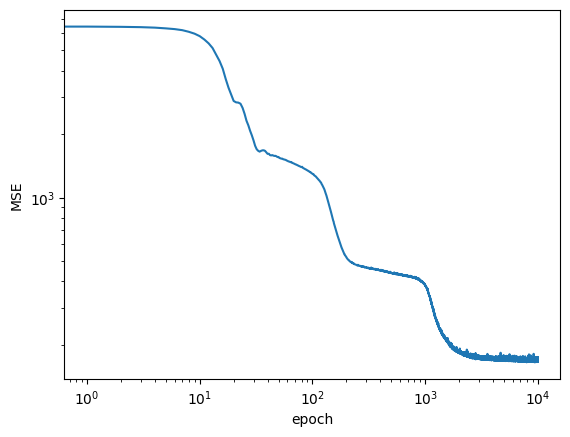

In [56]:
plt.loglog(logs)
plt.xlabel('epoch')
plt.ylabel('MSE')

Adam has some hyperparameters: the learning rate (too small is slow, too large might miss the solution), learning rate decay (smaller updates near the optimum), and momentum decay (for which built-in defaults are usually good enough).

Now we can see how the final model performs:

Text(0, 0.5, 'y')

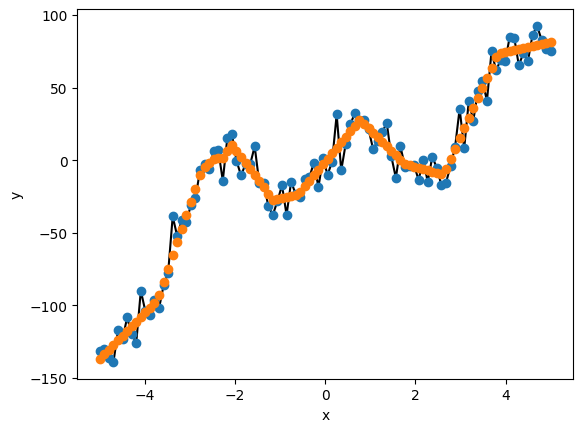

In [57]:
# let's check our predictions
x_ = torch.from_numpy(xxx.astype('float32'))
ypred = model(torch.reshape(x_, (len(x_), 1))).squeeze().cpu().detach().numpy()

plt.plot(xxx, yyy, color='k')
plt.plot(xxx, yyy, 'o', color='C0')
plt.plot(xxx, ypred, 'o', color='C1')
plt.xlabel('x')
plt.ylabel('y')